In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats import proportion

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Preface

The motivation for this tutorial is to better understand the methods to assess the results of A/B(/C...) tests.
There are so many common pitfalls when it comes to A/B tests; make sure you avoid them!
For example, [this check list](https://blog.hubspot.com/marketing/a-b-test-checklist) might be a good reference.

A common and repeating question is how to check the significance of the results of an A/B test.
[Matt Brems](https://stats.stackexchange.com/a/178860/54320) provided a very nice summary.
I wanted to compare two of the tests suggested:

- [$z$-test](https://en.wikipedia.org/wiki/Z-test)
- [$\chi^2$-test](https://en.wikipedia.org/wiki/Chi-squared_test)


### The plan

Let us define $N$ to be a set of $u$ integers and $\Delta$ to be a set of $v$ real numbers.
For each $n \in N$ and $\delta \in \Delta$ we generate a synthetic results of an A/B test.
In particular the control and variant groups would have $\sim n$ observations.
The reason is that in real results of A/B tests, the groups sizes are normally not identical; they are close but not equal.
Furthermore, the control set would have a fixed $\mathrm{CTR}$ (click through rate) and the variant will have conversion rate of $\mathrm{CTR} + \delta$.

As the null hypothesis we take that the CTR of the control and variant groups is the same, independently of the treatment.
Thus a small $p$-value should suggest to reject the null hypothesis.
For each synthetic result we will compute the $p$-value using a $z$-test and a $\chi^2$-test.
In general, we expect that the smaller $n$ is and the larger $\delta$, the resulting $p$-value would be larger.

## Generate data

### Groups' sizes

In reality, even though we assume the users are split randomly and evenly, the final groups' sizes are not identical.
Therefore, we randomize the group size:

In [2]:
def rand_group_size(N, tol=0.05):
    return N + np.random.randint(
        min(-tol * N, -1), 
        max(tol * N, 1) + 1)

### Event's value

For each successful event we assign a value.
To that end we use a truncated uniform distribution providing the `low` and `up` values, together with the mean (`mu`) and standard deviation (`sigma`).

In [3]:
def rand_values(low, up, mu, sigma, N):
    return stats.truncnorm(
        (low - mu) / sigma,
        (up  - mu) / sigma,
        loc=mu, scale=sigma).rvs(N)

### Generating the data for a group

When generating an observation, the following features are randomized:

* The group size; controlled by `N` (~size) and `N_tol`. See `rand_group_size`
* Name of the group. Normally `control` or `var`. Configured by `treat`.
* Randomly assign `1` is the event was converted and `0` otherwise. The randomness is controlled by the weight`ctr`
* In case of conversion what was the value; controlled by: `min_val`, `max_val`, `mean_val` and `std_val`
* What day of the test is it; controlled by number of `days` and the distribution `days_dist`
* `seed` can help you reproduce the results.

In [4]:
def generate_group_observations(N=1000, N_tol=0.05,
                                treat='control',
                                ctr=0.2,
                                min_val=None, max_val=None,
                                mean_val=None, std_val=None,
                                days=7, days_dist=[1/7] * 7,
                                verbose=True,
                                seed=42
                               ):
    if verbose:
        print('Generating ~{N} samples with tolerance {tol}'.format(N=N, tol=N_tol))
        print('CTR: {ctr}'.format(ctr=ctr))
        print('Min value: {min_val} / Max value: {max_val}'.format(min_val=min_val,
                                                                   max_val=max_val))
        print('Value mean: {mean_val} / Value STD: {std_val}'.format(mean_val=mean_val,
                                                                     std_val=std_val))
        print('Generating observation over {days} days with {dist} as the distribution'.format(
            days=days, dist=days_dist
        ))
    if seed is not None:
        np.random.seed(seed)
    N = rand_group_size(N=N, tol=N_tol)
    converts = np.random.choice([0, 1], size=N, p=[1 - ctr, ctr])
    values = np.multiply(rand_values(min_val, max_val, mean_val, std_val, N), converts)
    day = np.random.choice(np.arange(0, days), p=days_dist, size=N)
    return pd.DataFrame(
        {
            "Treat": [treat] * N,
            "Day": day,
            "Converted": converts,
            "Value": values
        }
    )

Here is an example of ~10 observation (for a single group) spread along two days

In [5]:
generate_group_observations(
    N=10, days=2, days_dist=[0.4, 0.6],
    min_val=30, max_val=100, mean_val=60, std_val=20, seed=314)

Generating ~10 samples with tolerance 0.05
CTR: 0.2
Min value: 30 / Max value: 100
Value mean: 60 / Value STD: 20
Generating observation over 2 days with [0.4, 0.6] as the distribution


,Converted,Day,Treat,Value
0,1,1,control,58.682799
1,0,1,control,0.000000
2,1,1,control,83.425302
3,0,0,control,0.000000
4,1,0,control,37.115954
5,1,0,control,85.991153
6,0,1,control,0.000000
7,0,1,control,0.000000
8,1,1,control,53.225721


We are now ready to generate a synthetic results set of an A/B test, using the following function.

In [6]:
def generate_observations(N=1000,
                          control_ctr=0.2,
                          control_min_value=50,
                          control_max_value=150,
                          control_mean_sale=80,
                          control_std_sale=20,
                          var_ctr=0.15,
                          var_min_value=50,
                          var_max_value=150,
                          var_mean_sale=90,
                          var_std_sale=30,
                          days=7, days_dist=[1/7] * 7,
                          seed=42,
                          verbose=True
                         ):
    np.random.seed(seed)
    control = generate_group_observations(N=N, days=days, days_dist=days_dist, 
                                          ctr=control_ctr, min_val=control_min_value, max_val=control_max_value, 
                                          mean_val=control_mean_sale, std_val=control_std_sale,
                                          treat='control',
                                          seed=None, verbose=verbose
                                         )
    var = generate_group_observations(N=N, days=days, days_dist=days_dist, 
                                      ctr=var_ctr, min_val=var_min_value, max_val=var_max_value, 
                                      mean_val=var_mean_sale, std_val=var_std_sale,
                                      treat='var',
                                      seed=None, verbose=verbose
                                     )

    results = pd.concat([control, var]).reset_index(drop=True)
    return results

Here's a ~10 days X 2 (for *control* and *variation* groups) results set

In [7]:
generate_observations(N=10, seed=262, verbose=False)

,Converted,Day,Treat,Value
0,0,1,control,0.000000
1,1,6,control,90.575667
2,0,2,control,0.000000
3,0,0,control,0.000000
4,0,3,control,0.000000
5,0,6,control,0.000000
6,0,3,control,0.000000
7,1,5,control,88.962021
8,0,2,control,0.000000
9,0,3,control,0.000000


## Conversion rate

At this point we want to aggregate the results and compute the metric (a.k.a. proportion) we are after.
In this example we consider the conversion rate.

In [8]:
def agg_conversion(results):
    conversions = results.groupby('Treat')['Converted'].agg(['count', 'sum'])
    conversions.rename(columns={'count': 'Visitors', 'sum': 'Converted'}, inplace=True)
    conversions['Not_converted'] = conversions.Visitors - conversions.Converted
    conversions['CR'] = conversions.Converted / conversions.Visitors
    return conversions

For the conversion rate we aggregate the raw events into a *contingency* matrix.
Here is the resulting aggregation of the data generated previously.

In [9]:
agg_conversion(generate_observations(N=10, seed=262, verbose=False))

,Visitors,Converted,Not_converted,CR
Treat,,,,
control,10,2,8,0.200000
var,9,2,7,0.222222


### Conversion rate and sample size

In this example (you have to run the notebook interactively) you can witness how the smaller the sample size is the further off the conversion rate is from the one prescribed in the generation function.

1. Fix the conversion rate for the control and variation groups
2. Play around with $N$. Note that the larger $N$ is the aggregation of the results gets closers to the values set.

For every value of $N$ we generate a synthetic data set and aggregate it to get the observed *conversion rate*.
The synthetic 

In [10]:
interact(
    lambda N, control_ctr, var_ctr: print(
        agg_conversion(
            generate_observations(
                seed=None, verbose=False, 
                N=N, 
                control_ctr=control_ctr,
                var_ctr=var_ctr
            ))['CR']
        ), 
    control_ctr=widgets.FloatSlider(value=0.2, min=0, max=1, step=0.05, description='Control CR'),
    var_ctr=widgets.FloatSlider(value=0.15, min=0, max=1, step=0.05, description='Variation CR'),
    N=widgets.IntSlider(min=10,max=5000,step=100,value=1000)
);

interactive(children=(IntSlider(value=1000, description='N', max=5000, min=10, step=100), FloatSlider(value=0.2, description='Control CR', max=1.0, step=0.05), FloatSlider(value=0.15, description='Variation CR', max=1.0, step=0.05), Output()), _dom_classes=('widget-interact',))

## Experimenting with different statistical tests

First, here is a simple utility to plot a heat map of the the resulting $p$-values.

In [11]:
def plot_experiment(df):
    """
    Utility function to plot a heatmap of the resulting p-values
    """
    plt.figure(figsize=(10,10))
    ax = sns.heatmap(df, cmap=plt.cm.Blues, linecolor='gray',
                     xticklabels=df.columns.values.round(2),
                     linewidths=.02
                    )
    ax.set(xlabel='CR delta', ylabel='N')
    ax.set_yticklabels(rotation=0, labels=Ns);

As discussed in the outline, we generate results for various $n$'s and various CTRs of the variant group.

In [12]:
def generate_data(control_ctr, deltas, Ns, seeds_seed=None):
    """
    Generate data for len(Ns)*len(deltas) experiment.
    Each experiment has ~N observation in each group and
    the CTR of the variation is control_ctr+delta
    """
    if seeds_seed is not None:
        np.random.seed(seeds_seed)
    seeds = np.random.randint(0, 2**32 - 1, size=(len(Ns), len(deltas)))
    experiments = [
        [
            generate_observations(
                N=N, control_ctr=control_ctr,
                var_ctr = control_ctr + delta,
                seed=seeds[i][j] if seeds_seed is not None else None,
                verbose=False
            ) for j, delta in enumerate(deltas)
        ] for i, N in enumerate(Ns)
    ]
    return pd.DataFrame(experiments, index=Ns, columns=deltas)

*Finally*, generating the data:

In [13]:
deltas = np.linspace(-0.15, 0.15, num=31)
Ns = np.round(np.linspace(10, 10000, num=40)).astype('int64')

data = generate_data(seeds_seed=262, control_ctr=0.2, 
                     deltas=deltas, Ns=Ns,
                    )

For each A/B test we aggregate the data:

In [14]:
data_agg = data.applymap(agg_conversion)

Utility function to element-wise $p$-value computation:

In [15]:
def compute_proportions_pvals(data_agg, test):
    """
    Compute the p-value of a single A/B test.
    `test` is assumed to be from `statsmodels.stats.proportion`
    """
    return data_agg.applymap(lambda x: test(x['Converted'], x['Visitors'])[1])

#### $\chi^2$ independence test

/Users/drorata/anaconda3/envs/z-vs-ch2-tests/lib/python3.6/site-packages/scipy/stats/stats.py:4554: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


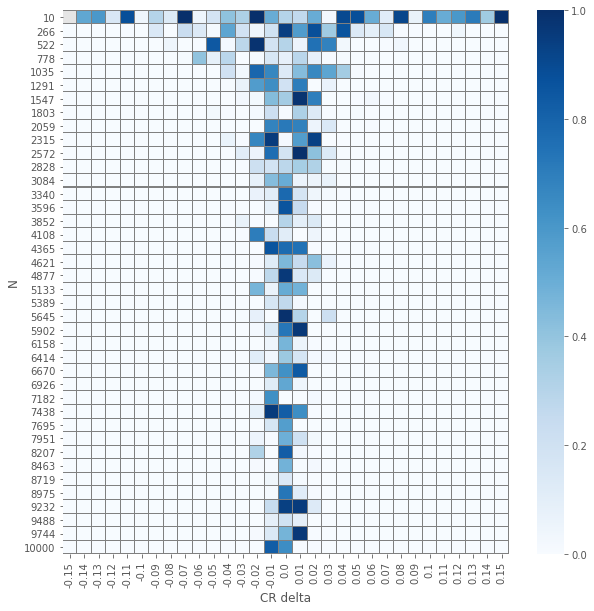

In [16]:
pvals_chi2 = compute_proportions_pvals(data_agg, proportion.proportions_chisquare)
plot_experiment(pvals_chi2)

### $z$ test

/Users/drorata/anaconda3/envs/z-vs-ch2-tests/lib/python3.6/site-packages/statsmodels/stats/weightstats.py:670: RuntimeWarning: invalid value encountered in double_scalars
  zstat = value / std_diff


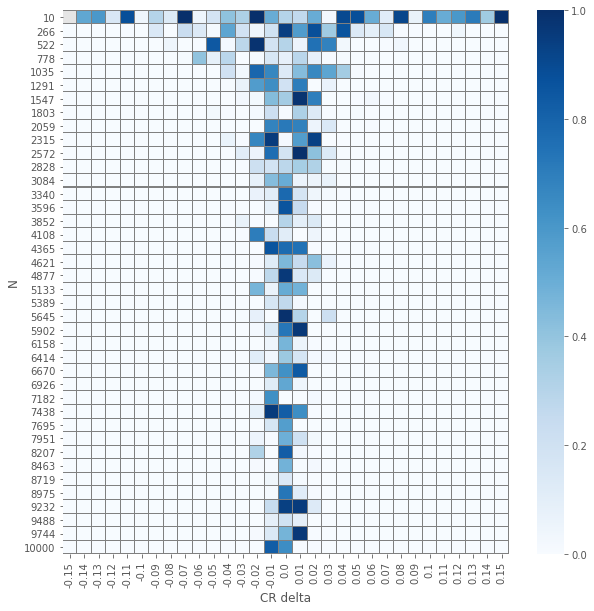

In [17]:
pvals_z = compute_proportions_pvals(data_agg, proportion.proportions_ztest)
plot_experiment(pvals_z)

## Comparing $z$-test and $\chi^2$ test

The results of the element-wise $z$ and $\chi^2$ tests yields an expected visualization.
The smaller the number of samples per group $N$ is and the smaller $\delat$ is we have $p$-values that are larger.
But, and it is not a huge surprise, the visuals for the two different tests seems similar.
Let us check how close are they.

In [18]:
pvals_diffs_close = pd.DataFrame(np.isclose(pvals_chi2, pvals_z))

In [19]:
pvals_diffs = (pvals_chi2 - pvals_z).abs()

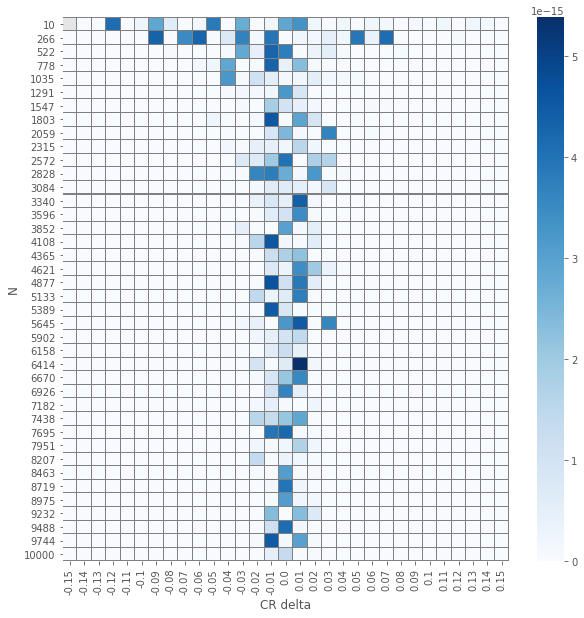

In [20]:
plot_experiment(pvals_diffs)

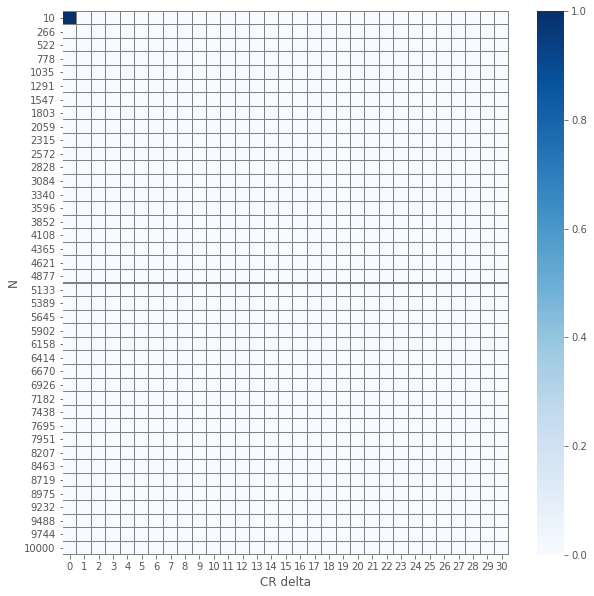

In [21]:
plot_experiment(pvals_diffs_close.applymap(lambda x: 0 if x else 1))

So we see that except a single(!) case, all $p$-values are the same!